# CONVOLUTIONAL NEURAL NETWORK WITH KERAS

### This example will walk through the steps to define and run a CNN to solve the handwritten character recognition problem.

#### The network used is an updated version of LeNet5 - which took 2 weeks to train in its first configuration back in the 1990's!

##### As usual let's start by importing modules

In [1]:
import tensorflow as tf
import os

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import sys
import numpy as np

##### As a reporting check let's see the versions of all the packages we are using

In [2]:
from tensorflow.python.platform import build_info

print('Python version : ', sys.version)
print('Keras version : ', tf.keras.__version__)
print('tensorflow versio : ', tf.__version__)
print('cuda version',build_info.build_info['cuda_version'])

Python version :  3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
Keras version :  2.9.0
tensorflow versio :  2.9.0
cuda version 11.2


#### The MNIST dataset of handwritten numbers is available as a standard within keras. Let's load it and see the frirst five entries

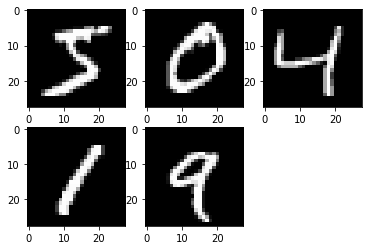

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

%matplotlib inline
plt.subplot(231)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(232)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(233)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(234)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.subplot(235)
plt.imshow(x_train[4], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

### We need a few layer types to build our model

#### Import them from the tensorflow keras library


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

##### Some housekeeping before we start

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(7)

## Data Preparation

##### The CNN inputs expect 3 dimensions for input images [height][width][channels]. For an RGB the channels value would be 3 representing the red, green and blue components, in our case, the MNIST images are grey scale so the channel dimension is set to 1.

##### Having set the channel count we need to rescale the images to have values in range 0..1 rather than 0..255

##### And finally change the y values into a "one-hot" encoding format

In [6]:
print('Initially:',chr(9), 'x_train shape:', x_train.shape, ' Range ', x_train.min(), ' to ',x_train.max())

input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], input_shape[0], input_shape[1], input_shape[2] )
x_test = x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], input_shape[2])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print('Modified to:',chr(9), 'x_train shape:', x_train.shape, ' Range ', x_train.min(), ' to ',x_train.max())

Initially: 	 x_train shape: (60000, 28, 28)  Range  0  to  255
Modified to: 	 x_train shape: (60000, 28, 28, 1)  Range  0.0  to  1.0


In [7]:
print('The initial 5 values for y are')
print(y_train[0:5])

num_classes = 10
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

print()
print('And the one hot representations are')
print(y_train_oh[0:5])

The initial 5 values for y are
[5 0 4 1 9]

And the one hot representations are
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Now Define the Model

#### This model is the LeNet5 model with dropout layers added

#### The first layer takes the inputs and applies 32 different 5*5 convolution masks to generate 32 new images for each input
#### These are then reduced in size using the MaxPooling layer

#### We then have a further 64 5*5 masks applied to the outputs to generate 64 new images which are again reduced in size

#### The dropout layers randomly remove some results to prevent overfitting

#### Images are then flattened and a layer of 1000 neurons used to generate 1000 single values
#### These values are fed to the final 10 neurons and the neuron with highest output value in this final layer will correspond to the digit being forecast from the input image

In [8]:
def setup_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


model = setup_model()
        

### And let's see the model details

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

### Compile and fit the model. The CNN is fit over 10 epochs with a batch size of 512.

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_oh, batch_size=512, epochs=10, verbose=1, validation_data=(x_test, y_test_oh))

Epoch 1/10
118/118 [==============================] - 3s 11ms/step - loss: 0.2963 - accuracy: 0.9096 - val_loss: 0.0571 - val_accuracy: 0.9812
Epoch 2/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0684 - accuracy: 0.9791 - val_loss: 0.0342 - val_accuracy: 0.9891
Epoch 3/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0465 - accuracy: 0.9858 - val_loss: 0.0284 - val_accuracy: 0.9903
Epoch 4/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0238 - val_accuracy: 0.9925
Epoch 5/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.0257 - val_accuracy: 0.9921
Epoch 6/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0206 - val_accuracy: 0.9928
Epoch 7/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.0214 - val_accuracy: 0.9926
Epoch

In [ ]:
## After running the model we can see how the loss and accuracy evolved over the epochs

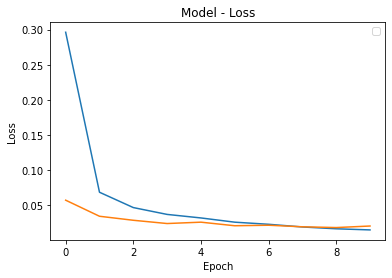

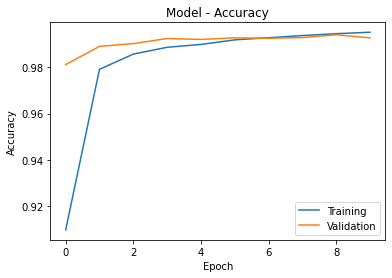

In [31]:
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model - Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## The model has been built, so let's use it to make predictions for all the test values

In [ ]:
y_pred = model.predict(x_test, use_multiprocessing=True).argmax(axis=1)

313/313 [==============================] - 0s 1ms/step


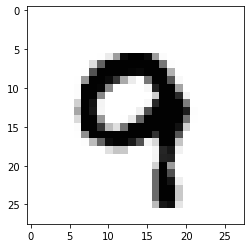

The Answer is  9


In [17]:
n = 99
plt.imshow(x_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()
print('The Answer is ', y_pred[n])

### Which ones did it get wrong

In [33]:
wrong_ones = (y_pred != y_test).sum()
print ("Number of wrong cases = %d"%wrong_ones)

Number of wrong cases = 72


In [34]:
WrongCases = np.where(y_pred != y_test)

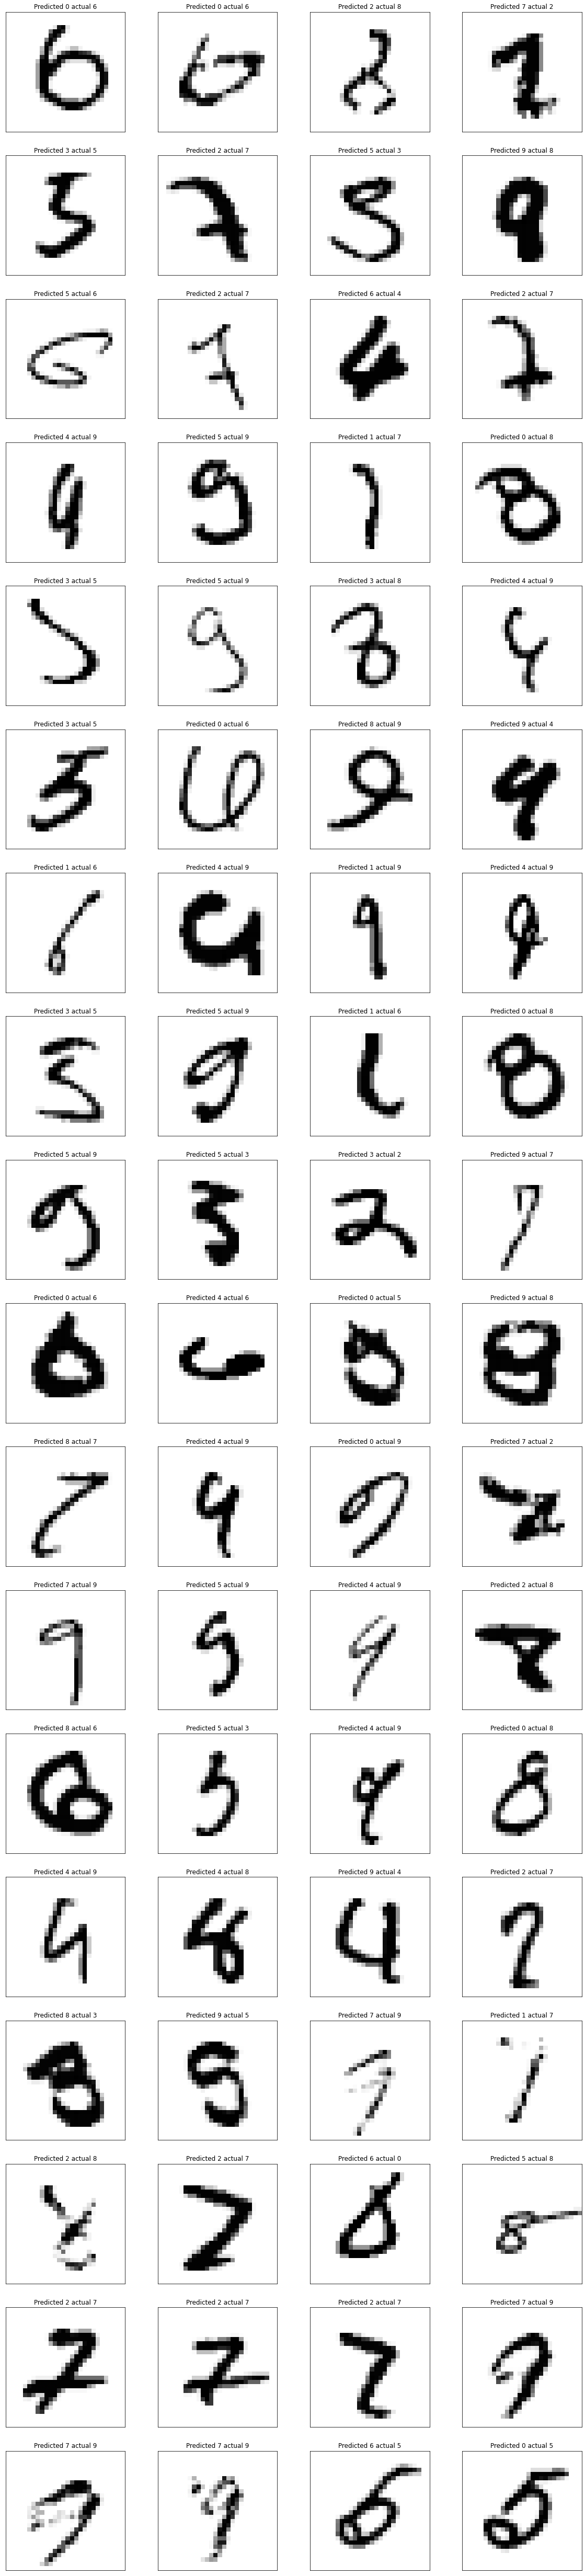

In [28]:
ncols = 4
nrows = int(np.ceil(wrong_ones/ncols))

plotnum = 0

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows), subplot_kw={'xticks': [], 'yticks': []})

row = 0
col = -1

for n in WrongCases[0]:
    col = col +1
    if col == ncols:
        col = 0
        row = row + 1    
    axs[row,col].imshow(x_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
    axs[row,col].set_title('Predicted %d actual %d' %(y_pred[n], y_test[n]), color='black')
    
for i in range(col + 1, ncols):
    axs[row,i].imshow(np.array([0,0,0,0]).reshape(2,2), cmap='Greys', interpolation='nearest')